In [1]:
from lmfit import minimize, Parameters # Parameter, report_fit

In [2]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ASTroCAT

(Allometric/Stochastic Trophic Complexity Analysis Tool)

This is a model presented by Neil Banas in the publication:
Banas, N. S. (2011). Adding complex trophic interactions to a size-spectral plankton model: Emergent diversity patterns and limits on predictability. Ecological Modelling, 222(15), 2663–2675. https://doi.org/10.1016/j.ecolmodel.2011.05.018

The basic implementation represents a 

The model, named ASTroCAT (Allometric/Stochastic Trophic Complexity Analysis Tool), is schematized in Fig. 1. It uses nitrogen as its currency (stocks are reported in units of µmol N m−3, or µM), with compartments for dissolved nutrients (N), 40 size classes of phytoplankton (P), and 40 classes of small zooplankton (Z). The ver- sion used here has been kept mechanistically minimal, containing only a single bottom-up control (nutrient limitation of P growth), a single top-down control (higher predation on Z), and one highly resolved level of trophic interactions (P–Z) in between. There is no light or temperature dependence to P growth, and no distinction made between the rate and timing of phytoplankton cell growth and the rate and timing of uptake of the limiting nutrient. The physical testbed is a single box, and the detrital pool and regeneration pathways are not tracked: mortality and zooplankton egestion (sloppy feeding) are treated as losses from the model nitrogen pool, and whatever fraction of these losses is ultimately regenerated is folded into an imposed, external nutrient supply (S). Thus the model can be thought of as an “open” or “flowthrough” NPZ system, as opposed to the classical “closed” NPZ system (Franks, 2002), which sends mortality and egestion losses directly back into the N pool. The minimalism of this model configuration makes the interpretation of results easier, but for a realistic application, one would, at a minimum, add light-dependence to phytoplankton growth, resolve at least one spatial dimension in the domain, and explicitly track detritus. 

The model equations are

![alt text](ASTroCAT_equations_full.jpg)

In [4]:
@xs.process
class UniqueComponent:
    """This is for initializing a Nutrient (i.e. components that are unique (0D))"""
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    
    def initialize(self):
        self.label = (self.component_label,)
        self.init = np.array(self.initVal)
        print('NutInit',self.init)
        

In [5]:
@xs.process
class Nutrient(UniqueComponent):
    component_label = xs.variable(default='N', groups='component-label')
    initVal = xs.variable(default=1)
    supplyrate = xs.variable(default=1)

    # Process variables
    supply = xs.variable(intent='out')
    
    def _supply(self):
        return self.supplyrate
    
    def initialize(self):
        super(Nutrient, self).initialize()
        self.supply = self._supply

In [6]:
@xs.process
class FlexSizeComponent:
    """This is for initializing both Phytoplankton and Zooplankton (i.e. components of variable number (1D))"""
    #flux = xs.variable(intent='out', groups='flux')
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    size = xs.variable(dims='flexComponent',intent='out', groups='size')
        
    def calculate_sizes(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize_alloparams(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        self.label = tuple((self.component_label + str(i) for i in range(self.NP)))
        self.init = np.array([self.initVal / self.NP for i in range(self.NP)])
        
        self.size = self.calculate_sizes()
        print(self.size)
        self.initialize_alloparams()

In [7]:
@xs.process
class Phytoplankton(FlexSizeComponent):
    component_label = xs.variable(default='P', groups='component-label')
    # Phytoplankton params
    PMinEsd = xs.variable(default = 1,  description='P max growth', groups='parameter', static=True)
    PMaxEsd = xs.variable(default = 20, description='P max growth', groups='parameter', static=True)
    NP =      xs.variable(default = 40, description='number of P',  groups='parameter', static=True)
    
    # INPUT
    initVal = xs.variable()
    m = xs.variable(default=.1)
    
    # Rate params
    ks = xs.variable(intent='out', description='allometric half-saturation constant',  groups='parameter')
    mu0 = xs.variable(intent='out', description='allometric growth rate',  groups='parameter')
    
    # Process variables
    uptake = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    grazed = xs.variable(intent='out')
    
    def _uptake(self, N):
        return self.mu0 * N / (N + self.ks)
    
    def _mortality(self):
        """returns size-scaled mortality rate, calculated from mu0"""
        return self.m * self.mu0 
    
    def _grazed(self,FgrazP):
        return [sum(FgrazP[i,:]) for i in range(self.NP)]
    
    def calculate_sizes(self):
        numbers = np.array([i for i in range(self.NP)])
        sizes = (np.log(self.PMaxEsd) - np.log(self.PMinEsd))* numbers / (self.NP-1) + np.log(self.PMinEsd)
        return np.exp(sizes)
    
    def initialize_alloparams(self):
        # must be implemented in subclasses
        self.mu0 = 2.6 * (self.size) ** -0.45
        self.ks = (self.size) * .1
        
    def initialize(self):
        super(Phytoplankton, self).initialize()
        self.uptake = self._uptake
        self.mortality = self._mortality
        self.grazed = self._grazed
        print('ks',self.ks)
        print('mu0',self.mu0)


In [8]:
@xs.process
class Zooplankton(FlexSizeComponent):
    component_label = xs.variable(default='Z', groups='component-label')
    # SetupParams
    PMinEsd = xs.foreign(Phytoplankton, 'PMinEsd')
    PMaxEsd = xs.foreign(Phytoplankton, 'PMaxEsd')
    NP =      xs.foreign(Phytoplankton, 'NP')
    phytosize = xs.foreign(Phytoplankton, 'size')
   
    # Zooplankton params 
    initVal = xs.variable()
    zeta = xs.variable(default=1) #mortality rate quadratic
    deltaxprey = xs.variable(default=0.25) # log10 prey size tolerance
    KsZ = xs.variable(default=3) # grazing half saturation constant
    f_eg = xs.variable(default=.33) # egested food
    epsilon = xs.variable(default=.33) # assimilated food
    
    
    # Alloparams
    I0 = xs.variable(intent='out')
    xpreyopt = xs.variable(intent='out')
    
    phiP = xs.variable(intent='out')
    
    # Process variables
    grazingmatrix = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    ingestion = xs.variable(intent='out')
    excretion = xs.variable(intent='out')
    
    def _grazingmatrix(self,P,Z):
        PscaledAsFood = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):
                PscaledAsFood[i,j] = self.phiP[i,j] / self.KsZ * P[i]
        
        FgrazP = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):        
                FgrazP[i,j] = self.I0[j] * Z[j] * PscaledAsFood[i,j] / (1 + sum(PscaledAsFood[:,j]))
                
        return FgrazP
    
    def _ingestion(self,FgrazP):
        return [self.epsilon * sum(FgrazP[:,j]) for j in range(self.NP)]

    def _excretion(self,FgrazP):
        return [(1 - self.f_eg - self.epsilon) * sum(FgrazP[:,j]) for j in range(self.NP)]
    
    def _mortality(self,Z):
        return self.zeta * sum(Z)
        
    def calculate_sizes(self):
        zoosizes= 2.16 * self.phytosize ** 1.79
        return zoosizes
    
    def initialize_alloparams(self):
        # initializes allometric parameters as lists, based on sizes
        self.I0 = 26 * (self.size) ** -0.4
        self.xpreyopt = self.phytosize #0.65 * (self.size) ** .56 
    
    def init_phiP(self):
        """creates array of feeding preferences [P...P10] for each [Z]"""
        phiP= np.array([[np.exp(-((np.log10(xpreyi)-np.log10(xpreyoptj)) / self.deltaxprey)**2) 
               for xpreyi in self.phytosize] for xpreyoptj in self.xpreyopt])
        return phiP
    
    def initialize(self):        
        super(Zooplankton, self).initialize()
        self.grazingmatrix = self._grazingmatrix
        
        self.mortality = self._mortality
        self.ingestion = self._ingestion
        self.excretion = self._excretion
        
        self.phiP = self.init_phiP()
        print(self.phiP)
        print('preyopt',self.xpreyopt)



In [9]:
import itertools

def flatten(generatorlist):
    # returns 1D list from nested generator or multi-D list
    return list(itertools.chain.from_iterable(generatorlist))

In [10]:
@xs.process
class Chemostat:
    # foreign processes
    N_supply = xs.foreign(Nutrient, 'supply')
    
    P_uptake = xs.foreign(Phytoplankton, 'uptake')
    P_mortality = xs.foreign(Phytoplankton, 'mortality')
    
    grazingmatrix = xs.foreign(Zooplankton, 'grazingmatrix')
    Z_ingestion = xs.foreign(Zooplankton, 'ingestion')
    Z_excretion = xs.foreign(Zooplankton, 'excretion')
    Z_mortality = xs.foreign(Zooplankton, 'mortality')
    P_grazed = xs.foreign(Phytoplankton, 'grazed')
    
    # model construct labels
    complabels = xs.group('component-label')
    labels = xs.group('label')
    inits = xs.group('init')
    
    # output variables
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        self.time = 0

        # This is one of those things I am not sure about, it makes sense to use dicts to store model state (to allow calling different components by labels)
            # BUT this can not be used (afaik) in a nice way as output for plotting later on in the model output xarray.. do you have any idea how to do that more nicely?
        self.state = {label:val for label,val in zip(self.complabels,self.inits)}

        # in order to have output to plot, I also create an array that contains all output:
            # i have to use flatten function (defined above) to make group generators one dimensional (FlexComponents are Lists, so generators return List of Lists)
            # there should be a better solution to this.. but it relates to how xs.group() works in this model setup
        self.stateout = np.concatenate([self.state[label] for label in flatten(self.complabels)], axis=None)
        
        self.component = [i for i in flatten(self.labels)]
    
    def ode(self, state, time, labels, timestep):
        N, P, Z = state['N'], state['P'], state['Z']
        
        #P[P < 0.01] = 0.011
        #Z[Z < 0.01] = 0.011
        
        PGrazed = self.grazingmatrix(P,Z)

        dNdt = self.N_supply() - sum(self.P_uptake(N)*P) + sum(self.Z_excretion(PGrazed))
        
        dPdt = self.P_uptake(N)*P - self.P_mortality()*P - self.P_grazed(PGrazed)
        
        dZdt =  self.Z_ingestion(PGrazed) - self.Z_mortality(Z)*Z 
        
        # need to convert fluxes to correct time step by multiplying by dt        
        return {'N':dNdt*timestep, 'P':dPdt*timestep, 'Z':dZdt*timestep}

    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        self.outflux = self.ode(self.state,self.time,self.labels, dt)
        # {label : self.funcs[label](self.state, self.time, self.labels) * dt for label in self.complabels}
        
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label : self.state[label] + self.outflux[label] for label in self.complabels}
        
        self.stateout = np.concatenate(flatten([(self.state[label] for label in self.complabels)]), axis=None)



In [11]:
modmod = xs.Model({'env':Chemostat, 'N':Nutrient, 'P':Phytoplankton, 'Z':Zooplankton})

In [12]:
"""
!   PMinEsd = xs.variable(default = 1,  description='P max growth', groups='parameter', static=True)
    PMaxEsd = xs.variable(default = 20, description='P max growth', groups='parameter', static=True)
    NP =      xs.variable(default = 40, description='number of P',  groups='parameter', static=True)
    
    # INPUT
    initVal = xs.variable()
    m = xs.variable(default=.1)
    
    initVal = xs.variable(default=1)
    supplyrate = xs.variable(default=1)
    # Zooplankton params 
    initVal = xs.variable()
    zeta = xs.variable(default=1) #mortality rate quadratic
    deltaxprey = xs.variable(default=0.25) # log10 prey size tolerance
    KsZ = xs.variable(default=3) # grazing half saturation constant
    f_eg = xs.variable(default=.33) # egested food
    epsilon = xs.variable(default=.33) # assimilated food
"""

"\n!   PMinEsd = xs.variable(default = 1,  description='P max growth', groups='parameter', static=True)\n    PMaxEsd = xs.variable(default = 20, description='P max growth', groups='parameter', static=True)\n    NP =      xs.variable(default = 40, description='number of P',  groups='parameter', static=True)\n    \n    # INPUT\n    initVal = xs.variable()\n    m = xs.variable(default=.1)\n    \n    initVal = xs.variable(default=1)\n    supplyrate = xs.variable(default=1)\n    # Zooplankton params \n    initVal = xs.variable()\n    zeta = xs.variable(default=1) #mortality rate quadratic\n    deltaxprey = xs.variable(default=0.25) # log10 prey size tolerance\n    KsZ = xs.variable(default=3) # grazing half saturation constant\n    f_eg = xs.variable(default=.33) # egested food\n    epsilon = xs.variable(default=.33) # assimilated food\n"

In [22]:
mom_in = xs.create_setup(
        model=modmod,
    clocks={
         'time': np.linspace(1,10*365,10*365*9)  # 20,1000)
     },
    input_vars={
        'P__initVal':1,
        'Z__initVal':1
    },
    output_vars={
        'env__component': None,
        'P__size': None,
        'Z__size': None,
        'env__stateout': 'time'
    }
)

In [23]:
mom_out = mom_in.xsimlab.run(model=modmod)

[ 1.          1.07984083  1.16605621  1.2591551   1.35968709  1.46824563
  1.58547158  1.71205694  1.84874898  1.99635463  2.15574523  2.32786172
  2.51372012  2.71441762  2.93113896  3.16516352  3.4178728   3.69075859
  3.98543181  4.30363198  4.64723752  5.0182768   5.41894018  5.85159284
  6.31878886  6.82328618  7.368063    7.95633524  8.59157563  9.27753413
 10.01826013 10.81812631 11.68185446 12.61454339 13.62169896 14.70926668
 15.8836667  17.15183178 18.52124822 20.        ]
ks [0.1        0.10798408 0.11660562 0.12591551 0.13596871 0.14682456
 0.15854716 0.17120569 0.1848749  0.19963546 0.21557452 0.23278617
 0.25137201 0.27144176 0.2931139  0.31651635 0.34178728 0.36907586
 0.39854318 0.4303632  0.46472375 0.50182768 0.54189402 0.58515928
 0.63187889 0.68232862 0.7368063  0.79563352 0.85915756 0.92775341
 1.00182601 1.08181263 1.16818545 1.26145434 1.3621699  1.47092667
 1.58836667 1.71518318 1.85212482 2.        ]
mu0 [2.6        2.51166355 2.42632838 2.34389253 2.26425747 2

In [24]:
mom_out

<xarray.Dataset>
Dimensions:             (component: 81, flexComponent: 40, time: 32850)
Coordinates:
  * time                (time) float64 1.0 1.111 1.222 ... 3.65e+03 3.65e+03
Dimensions without coordinates: component, flexComponent
Data variables:
    Z__zeta             int64 1
    P__PMinEsd          int64 1
    Z__epsilon          float64 0.33
    Z__KsZ              int64 3
    Z__deltaxprey       float64 0.25
    N__supplyrate       int64 1
    P__m                float64 0.1
    P__NP               int64 40
    N__component_label  <U1 'N'
    P__component_label  <U1 'P'
    Z__f_eg             float64 0.33
    Z__component_label  <U1 'Z'
    N__initVal          int64 1
    P__PMaxEsd          int64 20
    P__initVal          int64 1
    Z__initVal          int64 1
    env__stateout       (time, component) float64 0.025 0.025 ... 0.2012
    env__component      (component) <U3 'P0' 'P1' 'P2' 'P3' ... 'Z38' 'Z39' 'N'
    P__size             (flexComponent) float64 1.0 1.08 1.166 ... 18.52 20.0
    Z__size             (flexComponent) float64 2.16 2.478 2.844 ... 401.4 460.6

In [25]:
mom_out.to_netcdf('NEWOUT_ASTroCAT_10y_x9res.nc')

In [125]:
model_out2 = mom_out.set_index(component = 'env__component')

In [126]:
#mom_out2 = mom_out.set_index(component = 'env__component')
P_out = model_out2.env__stateout[:,1:41].T
Z_out = model_out2.env__stateout[:,41:81].T
N_out = model_out2.env__stateout[:,0]
#plt.show()
P_out

<xarray.DataArray 'env__stateout' (component: 40, time: 3650)>
array([[2.50000000e-02, 2.80992696e-02, 3.17508885e-02, ...,
        2.59501943e-01, 2.59508248e-01, 2.59514253e-01],
       [2.50000000e-02, 2.76377212e-02, 3.07367559e-02, ...,
        1.42601001e-18, 1.41331260e-18, 1.40072862e-18],
       [2.50000000e-02, 2.72153199e-02, 2.98222845e-02, ...,
        1.74530850e-28, 1.72221523e-28, 1.69943139e-28],
       ...,
       [2.50000000e-02, 2.49713417e-02, 2.49972209e-02, ...,
        2.17813189e-02, 2.17750648e-02, 2.17688689e-02],
       [2.50000000e-02, 2.49882435e-02, 2.50249597e-02, ...,
        7.86860082e-03, 7.86468071e-03, 7.86077888e-03],
       [2.50000000e-02, 2.50073169e-02, 2.50571003e-02, ...,
        2.69379838e-03, 2.69178626e-03, 2.68978015e-03]])
Coordinates:
  * time       (time) float64 1.0 1.1 1.2 1.299 ... 364.7 364.8 364.9 365.0
  * component  (component) object 'P0' 'P1' 'P2' 'P3' ... 'P37' 'P38' 'P39'

In [127]:
plt.rcParams['figure.figsize'] = [20, 5]

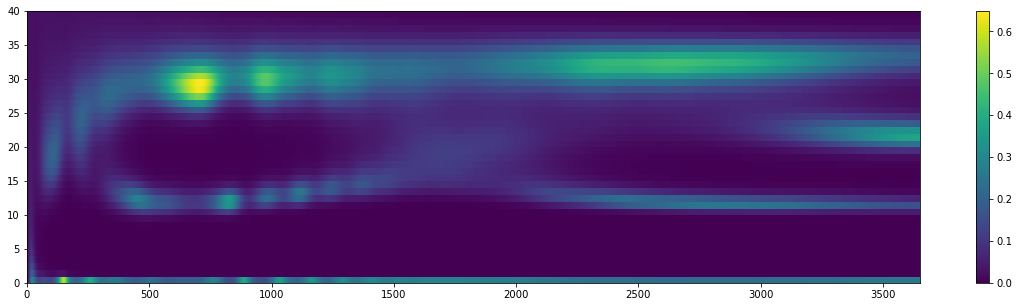

In [130]:
plt.pcolor(P_out)
plt.colorbar()
plt.show()

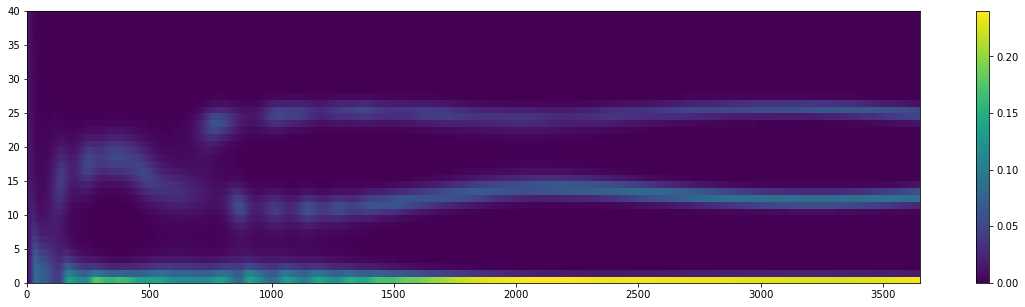

In [129]:
plt.pcolor(Z_out)
plt.colorbar()
plt.show()

# TODO
- implement an odeint routine that solves the model dynamically
- add plots of output to bottom
- fully document code
- 

# Open issues:

## 1. there must be a better way to keep track of the model state, right?
better than storing in a dict (with labels) and as a flattened list (for later plotting) at the same time.
Somewhat related to this problem is my use of FlexComponents, which necessitates putting lists in groups, therefore the generators return lists of lists, that do not correspond to the dimensionality needed in xarray. Perhaps the implementation of dimensions (i.e. coordinates and indices) could use an overhaul in this model, more in line with what you had in mind during the construction of xsimlab.

related to this question:
## 2. what is the best way to structure the xarray to contain all aspects of the model?
it should store all relevant inputs, outputs and parameters for later analysis in an easily accesible manner.

## 3. (not important) but would be amazing, if the visualization of the model represented ecological links & processes
by this I mean that the visualisation shows the components of the model as boxes (Nutrient, Phytoplankton, Zooplankton), and the defined processes on arrows between boxes (Nutrient --N_Uptake--> Phytoplankton).
If there was something in the model construction or the visualisation function that would allow this, it would be quite useful!

## 4. what is the best way to implement switching to odeint (unfixed steps)
model time should be handled in a nicerway, give range of time and timestep and model does the rest, both ways to solve it

## 5. how could this structure allow for an easy imlementation of dimensionality? 
so that there are multiple "chemostats" components interacting